In [1]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('SchizophreniaSymptomnsData.csv')
df.head()

,Name,Age,Gender,Marital_Status,Fatigue,Slowing,Pain,Hygiene,Movement,Schizophrenia
0,Leslie Goodwin,68,Female,Single,0.698075,0.123064,0.375303,0.234639,0.251869,Elevated Proneness
1,Dr. Troy Castaneda,88,Male,Married,0.049245,-0.042080,0.432807,0.501238,0.379948,Moderate Proneness
2,Chelsey Allen,67,Female,Married,0.651995,0.187117,NaN,0.301942,0.302588,Elevated Proneness
3,Dr. Devin Skinner DVM,95,Female,Widowed,0.036324,0.580808,0.005356,0.306968,0.813618,Moderate Proneness
4,Megan Mendez,81,Female,Widowed,0.926727,0.484202,0.702405,0.736054,0.579448,High Proneness


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Name            5000 non-null   object 
 1   Age             5000 non-null   int64  
 2   Gender          5000 non-null   object 
 3   Marital_Status  5000 non-null   object 
 4   Fatigue         4756 non-null   float64
 5   Slowing         4771 non-null   float64
 6   Pain            4758 non-null   float64
 7   Hygiene         5000 non-null   float64
 8   Movement        5000 non-null   float64
 9   Schizophrenia   5000 non-null   object 
dtypes: float64(5), int64(1), object(4)
memory usage: 390.8+ KB


In [5]:
df.describe()

,Age,Fatigue,Slowing,Pain,Hygiene,Movement
count,5000.00000,4756.000000,4771.000000,4758.000000,5000.000000,5000.000000
mean,74.83340,0.503835,0.499524,0.499612,0.499717,0.499952
std,9.57787,0.296123,0.295365,0.294886,0.294907,0.289860
min,55.00000,-0.095115,-0.094843,-0.095771,-0.094284,-0.089272
25%,67.00000,0.247056,0.245795,0.251174,0.248998,0.254143
50%,75.00000,0.506278,0.502403,0.498051,0.501223,0.503340
75%,83.00000,0.759499,0.744812,0.749946,0.751029,0.741253
max,95.00000,1.091136,1.092146,1.090027,1.086922,1.088914


In [6]:
df['Schizophrenia'].value_counts()

Schizophrenia
Elevated Proneness     3077
High Proneness          953
Moderate Proneness      912
Low Proneness            45
Very High Proneness      13
Name: count, dtype: int64

In [7]:
df.drop(columns=['Name'], inplace=True)

In [8]:
df.dropna(axis=0, inplace=True)

In [9]:
num_cols = df.select_dtypes(include=[np.number])

q1 = np.quantile(num_cols, 0.25, axis=0)
q2 = np.quantile(num_cols, 0.50, axis=0)
q3 = np.quantile(num_cols, 0.75, axis=0)
iqr = q3 - q1

upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

outliers = (num_cols < lower_bound) | (num_cols > upper_bound)
print("Jumlah nilai outlier per kolom:")
print(outliers.sum())

Jumlah nilai outlier per kolom:
Age         0
Fatigue     0
Slowing     0
Pain        0
Hygiene     0
Movement    0
dtype: int64


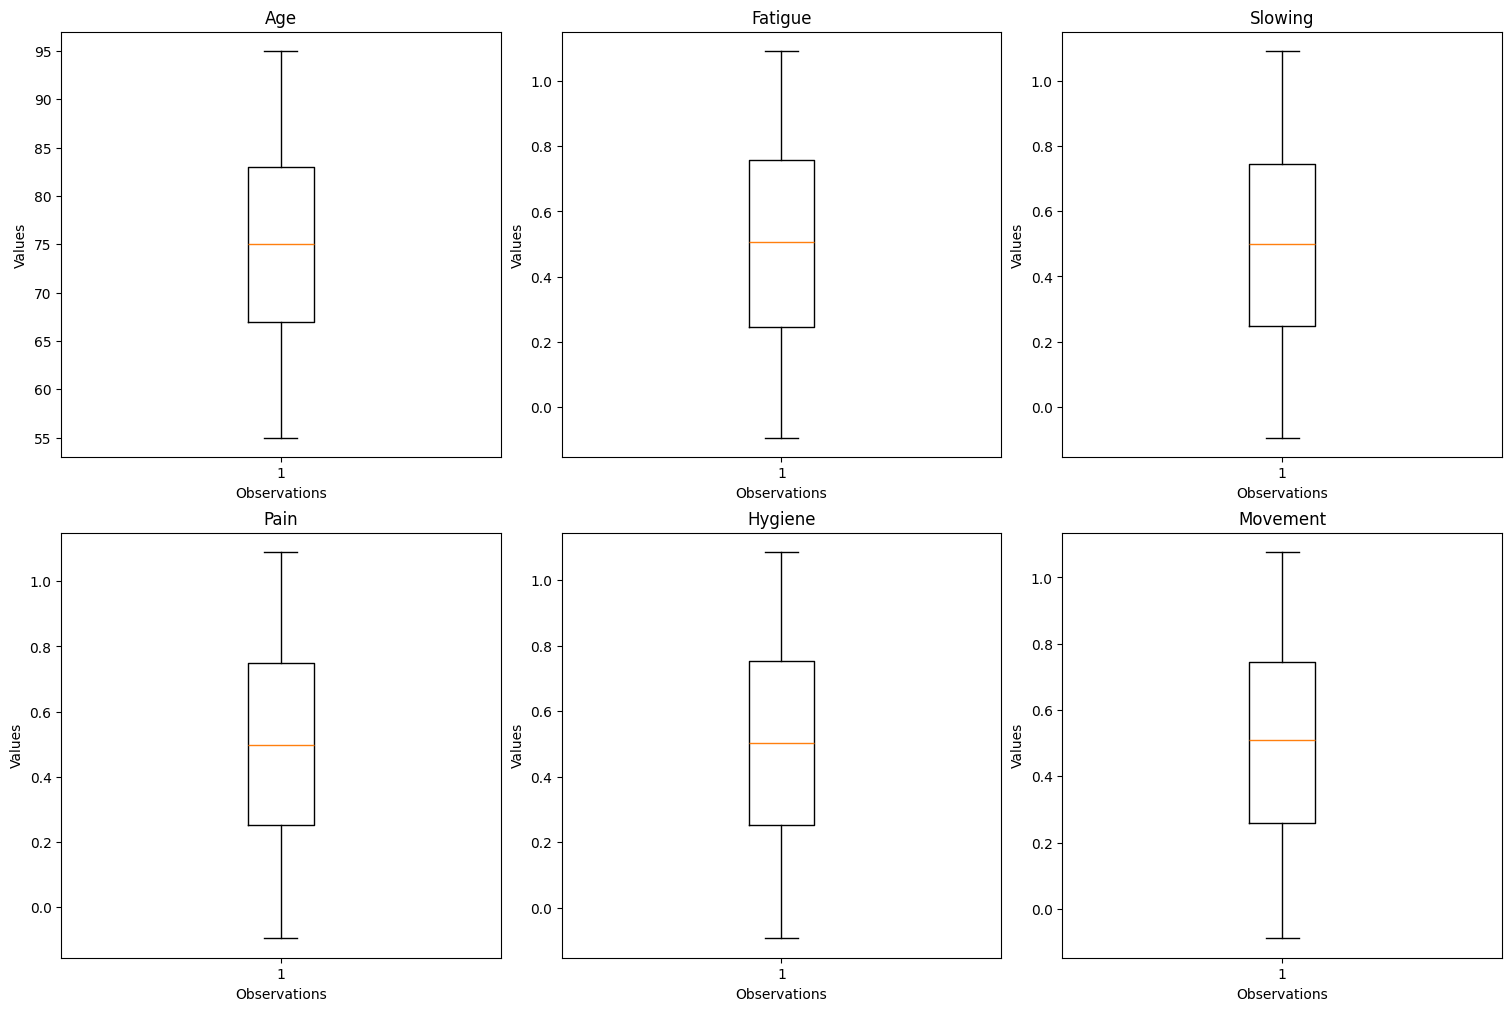

In [10]:
columns = ['Age',  'Fatigue', 'Slowing', 'Pain', 'Hygiene', 'Movement']

fig, axes = plt.subplots(2, 3, figsize=(15, 10), layout='constrained')
axes = axes.flatten() 

if len(columns) == 1:
    axes = [axes]

for i, col in enumerate(columns):
    axes[i].boxplot(df[col].dropna())
    axes[i].set_title(col)
    axes[i].set_xlabel('Observations')
    axes[i].set_ylabel('Values')

plt.show()

In [11]:
le_gender = LabelEncoder()
df['Gender'] = le_gender.fit_transform(df['Gender'])

marital_stat_map = {
    'Single': 0, 
    'Married': 1, 
    'Divorced': 2, 
    'Widowed': 3
}

label_map = {
    'Low Proneness' : 0,
    'Moderate Proneness' : 1,
    'Elevated Proneness' : 2,
    'High Proneness': 3,
    'Very High Proneness': 4
}

df['Marital_Status'] = df['Marital_Status'].map(marital_stat_map)
df['Schizophrenia'] = df['Schizophrenia'].map(label_map)

In [12]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X.shape, y.shape

((4318, 8), (4318,))

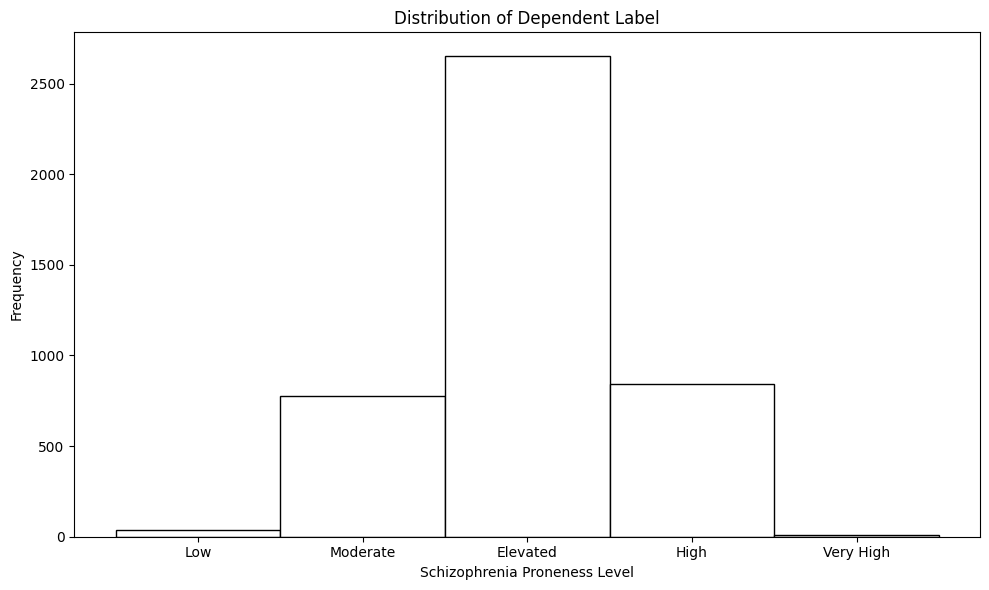

In [13]:
plt.figure(figsize=(10, 6))
plt.hist(df['Schizophrenia'], bins=np.arange(6)-0.5, edgecolor='black', color='white')
plt.title('Distribution of Dependent Label')
plt.xlabel('Schizophrenia Proneness Level')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(5), labels=['Low', 'Moderate', 'Elevated', 'High', 'Very High'])
plt.tight_layout()
plt.show()

In [14]:
sm = SMOTE(random_state=42)
X_sampling, y_sampling = sm.fit_resample(X, y)
X_sampling.shape, y_sampling.shape

((13250, 8), (13250,))

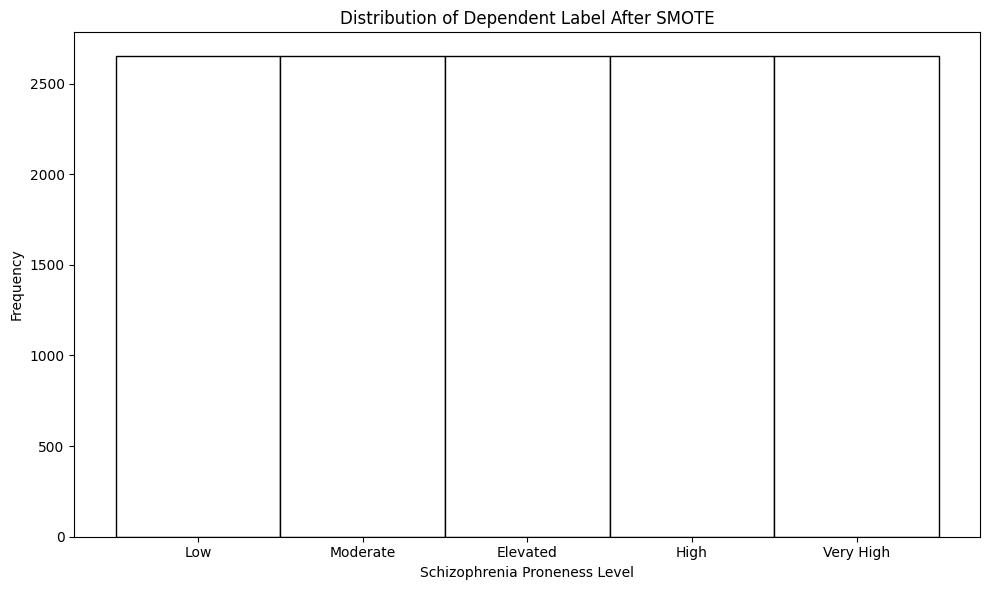

In [15]:
fig = plt.figure(figsize=(10, 6))
plt.hist(y_sampling, bins=np.arange(6)-0.5, edgecolor='black', color='white')
plt.title('Distribution of Dependent Label After SMOTE')
plt.xlabel('Schizophrenia Proneness Level')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(5), labels=['Low', 'Moderate', 'Elevated', 'High', 'Very High'])
plt.tight_layout()
plt.show()

In [16]:
df.shape

(4318, 9)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_sampling, y_sampling, test_size=0.2, random_state=42, stratify=y_sampling)

Accuracy: 0.9667924528301887
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       530
           1       0.96      0.97      0.97       530
           2       1.00      0.90      0.95       530
           3       0.94      0.96      0.95       530
           4       0.97      1.00      0.98       530

    accuracy                           0.97      2650
   macro avg       0.97      0.97      0.97      2650
weighted avg       0.97      0.97      0.97      2650



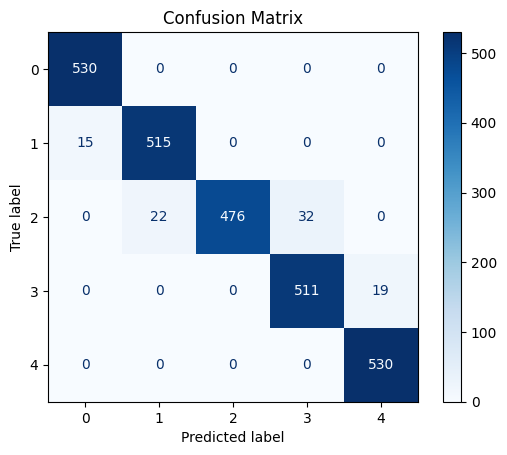

In [18]:
def no_norm (X_train, X_test):
    model = LogisticRegression(max_iter=2800)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    return model

no_norm_model = no_norm(X_train, X_test)

Accuracy: 0.9837735849056604
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       530
           1       0.98      0.98      0.98       530
           2       1.00      0.95      0.98       530
           3       0.97      0.98      0.98       530
           4       0.98      1.00      0.99       530

    accuracy                           0.98      2650
   macro avg       0.98      0.98      0.98      2650
weighted avg       0.98      0.98      0.98      2650



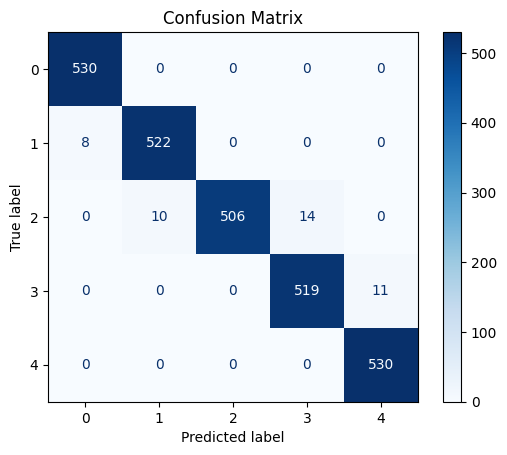

In [19]:
def zscore_norm (X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    return model

zscore_model = zscore_norm(X_train, X_test)

Accuracy: 0.9652830188679246
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       530
           1       0.96      0.97      0.96       530
           2       1.00      0.89      0.94       530
           3       0.94      0.96      0.95       530
           4       0.97      1.00      0.98       530

    accuracy                           0.97      2650
   macro avg       0.97      0.97      0.96      2650
weighted avg       0.97      0.97      0.96      2650



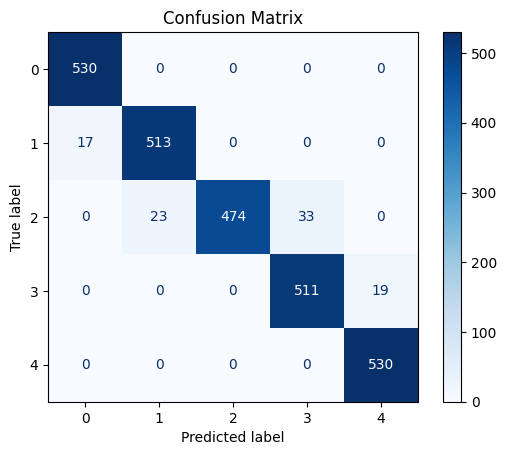

In [20]:
def minmax_norm (X_train, X_test):
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    return model

minmax_model = minmax_norm(X_train, X_test)

Accuracy: 0.47924528301886793
              precision    recall  f1-score   support

           0       0.49      0.89      0.63       530
           1       0.45      0.23      0.30       530
           2       0.49      0.17      0.26       530
           3       0.25      0.11      0.15       530
           4       0.53      1.00      0.69       530

    accuracy                           0.48      2650
   macro avg       0.44      0.48      0.41      2650
weighted avg       0.44      0.48      0.41      2650



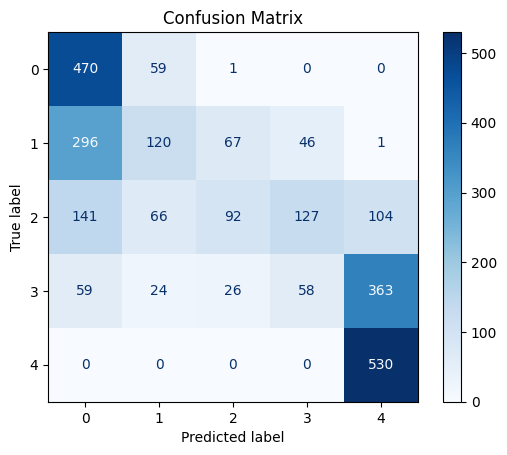

In [21]:
def l1_norm (X_train, X_test):
    scaler = Normalizer(norm='l1')
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    return model

l1_model = l1_norm(X_train, X_test)

Accuracy: 0.5592452830188679
              precision    recall  f1-score   support

           0       0.50      0.94      0.65       530
           1       0.58      0.35      0.44       530
           2       0.81      0.21      0.33       530
           3       0.65      0.34      0.45       530
           4       0.55      0.95      0.70       530

    accuracy                           0.56      2650
   macro avg       0.62      0.56      0.51      2650
weighted avg       0.62      0.56      0.51      2650



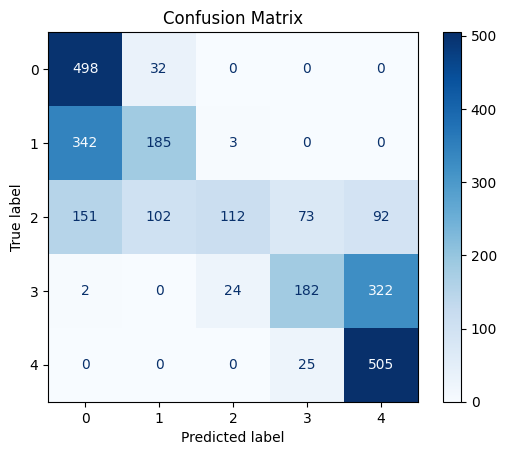

In [22]:
def l2_norm (X_train, X_test):
    scaler = Normalizer(norm='l2')
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression()
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred, zero_division=0))

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    return model

l2_model = l2_norm(X_train, X_test)